In [1]:
import colorsys
import gensim
from glove_code.src.glove import Glove
from gensim.models.callbacks import LossLogger, LossSetter
from gensim.models.keyedvectors import PoincareWordEmbeddingsKeyedVectors as pkv
from gensim.matutils import argsort
import json
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from numpy import dot
from operator import itemgetter
import os
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import RidgeCV
from nltk.corpus import wordnet as wn
from scipy import stats
from scipy.linalg import block_diag
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import sys
random.seed(42)

ROOT = "/Users/alext/Documents/Master/Thesis/"

init_notebook_mode(connected=True)

PLOTS_PER_ROW = 3

In [81]:
# hyp_model_fn = os.path.join(ROOT, "models/glove/geometric_emb/glove_ep50_size20_lr0.05_vocab200000_mix-poincare_OPTmixradagrad_COOCCFUNClog_DISTFUNCdist-sq_NUMEMBS10_bias")
hyp_model_fn = os.path.join(ROOT, "models/glove/geometric_emb/glove_ep50_size20_lr0.01_vocab200000_mix-poincare_OPTmixradagrad_COOCCFUNClog_DISTFUNCcosh-dist-sq_NUMEMBS10_bias")
# hyp_model_fn = os.path.join(ROOT, "models/glove/geometric_emb/glove_ep50_size100_lr0.05_vocab50000_mix-poincare_OPTmixradagrad_COOCCFUNClog_DISTFUNCdist-sq_NUMEMBS50_bias")

# hyp_model_fn = os.path.join(ROOT, "models/glove/geometric_emb/glove_ep50_size100_lr0.05_vocab200000_mix-poincare_OPTmixradagrad_COOCCFUNClog_DISTFUNCdist-sq_NUMEMBS50_bias")
# hyp_model_fn = os.path.join(ROOT, "models/glove/geometric_emb/glove_ep50_size100_lr0.01_vocab200000_mix-poincare_OPTmixradagrad_COOCCFUNClog_DISTFUNCcosh-dist-sq_NUMEMBS50_bias")
hyp_model = Glove.load(hyp_model_fn)
hyp_wv = hyp_model.wv

In [2]:
# Read wordnet noun transitive closure with levels.
level2words = [[] for i in range(20)]
for ss in wn.all_synsets():
    word, pos, _ = ss.name().rsplit(".", 2)
    if pos != "n":
        continue
    level = ss.max_depth()
    level2words[level].append(word)
for level, word_list in enumerate(level2words):
    print(level, len(word_list), word_list[0])

0 1 entity
1 3 physical_entity
2 22 thing
3 223 whole
4 1541 congener
5 4573 organism
6 8174 benthos
7 14831 beachhead
8 13350 agon
9 13775 abort
10 10847 abdominoplasty
11 6590 realization
12 3706 male_orgasm
13 1967 double_fault
14 1144 spiccato
15 644 highland_fling
16 458 carp
17 223 domestic_carp
18 42 leather_carp
19 1 rock_hind


In [23]:
# Get vocabulary from WordNet + labels for each section
def read_word_dict():
    result_dict = dict([(str(level), word_list[:50] + word_list[50::10]) for level, word_list in enumerate(level2words)])
    return result_dict

def HSVToRGB(h, s, v):
    (r, g, b) = colorsys.hsv_to_rgb(h, s, v)
    return (int(255*r), int(255*g), int(255*b))

def get_colors(word_dict):
    labels = word_dict.keys()
    huePartition = 1.0 / (len(labels) + 1)
    return dict(zip(labels, [HSVToRGB(huePartition * value, 1.0, 1.0) for value in range(0, len(labels))]))

def plot_ball_vectors(vectors, x, model, word_dict, ratio_words=0.1):
    colors = get_colors(labeled_word_dict)
    
    wv = model.wv
    embeddings = vectors

    traces = []
    small_emb_size = int(model.vector_size / model.num_embs)
    rows = int(np.ceil(model.num_embs / PLOTS_PER_ROW))
    fig = tools.make_subplots(rows=rows, cols=PLOTS_PER_ROW)
    for level, words in word_dict.items():
        if int(level) in range(4, 16):
            continue
            
        idxs = [wv.vocab[w].index for w in filter(lambda w: w in wv.vocab, words)]
        idxs = idxs[:int(len(idxs) * ratio_words)]

        embs = embeddings[idxs, :]

        for i in range(model.num_embs):
            row = int(i / PLOTS_PER_ROW) + 1
            col = i % PLOTS_PER_ROW + 1

            trace = go.Scatter(
                x=embs[:, small_emb_size * i],
                y=embs[:, small_emb_size * i + 1],
                text=[wv.index2word[idx] for idx in idxs],
                textposition='top right',
                name=level,
                mode="markers",
                marker=dict(color="rgb"+str(colors[level])))
            fig.append_trace(trace, row, col)

    layout = {
        'width': PLOTS_PER_ROW * 300,
        'height': rows * 300
    }
    
    if isinstance(model.wv, pkv):
        shapes = []
        for i, trace in enumerate(fig['data']):
            if i > 1: 
                trace['showlegend'] = False
            if i < model.num_embs and isinstance(model.wv, pkv):
                shapes.append(
                    # unfilled circle
                    {
                        'type': 'circle',
                        'xref': 'x'+str(i+1),
                        'yref': 'y'+str(i+1),
                        'x0': -1,
                        'y0': -1,
                        'x1': 1,
                        'y1': 1,
                        'line': {
                            'color': 'rgba(0, 0, 0, 1)',
                        },
                    }
                )

        layout['shapes'] = shapes
        
    fig["layout"].update(layout)
    
    return iplot(fig)

labeled_word_dict = read_word_dict()
len(labeled_word_dict)

20

In [7]:
hyperlex_file = os.path.join(ROOT, "data/hyperlex-data/hyperlex-all.txt")
wbless_file = os.path.join(ROOT, "data/BLESS_datasets/weeds_bless.json")

def read_hyperlex_format(filename):
    with open(filename, "r") as f:
        lines = [line.strip().split() for line in f.readlines()[1:]]
        result = []
        hyperlex_vocab = {}
        discarded_count = 0
        for line in lines:
            if line[0] not in hyp_wv.vocab or line[1] not in hyp_wv.vocab:
                discarded_count += 1
                continue
            result.append([line[0], line[1], hyp_wv.vocab[line[0]].index, hyp_wv.vocab[line[1]].index, float(line[5])])
            hyperlex_vocab[line[0]] = [line[0]]
            hyperlex_vocab[line[1]] = [line[1]]
        print("Discarded {} pairs out of {}".format(discarded_count, len(lines)))
        return np.array(result), hyperlex_vocab

def read_wbless(filename):
    with open(filename, "r") as f:
        wbless_data = json.load(f)
    
    wbless_vocab = {}
    for w1, w2, _ in wbless_data:
        wbless_vocab[w1] = w1
        wbless_vocab[w2] = w2
  
    return wbless_data, wbless_vocab

hyperlex_data, hyperlex_vocab = read_hyperlex_format(hyperlex_file)
wbless_data, wbless_vocab = read_wbless(wbless_file)

print(hyperlex_data[:10]) 
print(len(hyperlex_data), len(hyperlex_vocab))
print(len(wbless_data), len(wbless_vocab))

Discarded 4 pairs out of 2616
[['conflict' 'disagreement' '1489' '8101' '8.67']
 ['advance' 'take' '2500' '291' '2.37']
 ['trail' 'follow' '2318' '1724' '7.18']
 ['mason' 'worker' '5595' '5323' '7.5']
 ['aura' 'light' '19765' '572' '6.15']
 ['radish' 'carrot' '66122' '25731' '0.15']
 ['tusk' 'duty' '39108' '2439' '0.13']
 ['vehicle' 'motorcycle' '2028' '5903' '1.82']
 ['veal' 'meat' '48477' '4046' '9.77']
 ['keyboard' 'arm' '5948' '3050' '0.9']]
2612 2227
1668 656


In [3]:
def mix_poincare_moebius_add_mat(A, B, num_embs):
    small_emb_size = int(A.shape[1] / num_embs)
    result = np.empty_like(A)
    for i in range(num_embs):
        start = i * small_emb_size
        end = (i+1) * small_emb_size
        result[:, start:end] = pkv.moebius_add_mat(A[:, start:end], B[:, start:end])
    return result

def mix_poincare_moebius_mul_mat(A, r, num_embs):
    small_emb_size = int(A.shape[1] / num_embs)
    result = np.empty_like(A)
    for i in range(num_embs):
        start = i * small_emb_size
        end = (i+1) * small_emb_size
        result[:, start:end] = pkv.moebius_mul_mat(A[:, start:end], r)
    return result

def fisher_info_distance(v, w, num_embs):
    v = v.reshape(-1)
    w = w.reshape(-1)
    
    half_plane_dists = []
    small_emb_size = int(v.shape[0] / num_embs)
    
    if small_emb_size != 2:
        raise RuntimeError("Only implemented for Cartesian product of 2D spaces; Current small_emb_size is {}".format(
            small_emb_size))
    
    diff = v - w
    for i in range(num_embs):
        start = i * small_emb_size
        end = (i+1) * small_emb_size
        half_plane_dists.append(
            np.arccosh(1 + np.dot(diff[start:end], diff[start:end]) / (2 * v[start+1] * w[start+1]))
        )
    return np.linalg.norm(half_plane_dists) * np.sqrt(2)


# Rotate the rows of X. Each row is split into smaller 2D subspaces. sin_cos_vector contains (sin a, cos a) pairs,
# where a is the angle with which we rotate that 2D portion of a row of X.
def rotate_mat(sin_cos_vector, X):
    # Create rotation matrix.
    cos_sin_blocks = [[[c, -s], [s, c]] for s, c in sin_cos_vector.reshape(-1, 2)]
    rotation_matrix = cos_sin_blocks[0]
    for i in range(1, len(cos_sin_blocks)):
        rotation_matrix = block_diag(rotation_matrix, cos_sin_blocks[i])
        
    return (np.matmul(rotation_matrix, X.T)).T

def poincare_ball2half_plane(A, num_embs):
    small_emb_size = int(A.shape[1] / num_embs)
    result = np.empty_like(A)
    for i in range(num_embs):
        start = i * small_emb_size
        x = A[:, start]
        y = A[:, start + 1]
        denominator = x * x + (1 - y) * (1 - y)
        result[:, start] = 2 * x / denominator
        result[:, start + 1] = (1 - x * x - y * y) / denominator
    return result

recentered_vectors, rescaled_vectors, rotated_vectors = None, None, None
top_and_bottom_levels_avg, top_levels_avg, top_levels_avg_norm = None, None, None
def get_gaussians(model, aggregate="w", unsupervised=False, scaling_factor=1.0, words_to_use=400):
    global recentered_vectors, rescaled_vectors, rotated_vectors, top_and_bottom_levels_avg, top_levels_avg, top_levels_avg_norm
    
    wv = model.wv
    wordnet_selected_words_file = os.path.join(ROOT, "msc_tifreaa/glove_code/data/wordnet_topmost_and_bottommost_words.txt")
    with open(wordnet_selected_words_file, "r") as f:
        # Select words that are on the top-most/bottom-most levels in WordNet, that are included in the
        # vocabulary of the model AND that do not appear in any of the HyperLex pairs.
        top_level_word_idxs = np.array([wv.vocab[word].index for word in filter(
            lambda w: w in wv.vocab and w not in hyperlex_vocab and w not in wbless_vocab, f.readline().strip().split(" "))])
        bottom_level_word_idxs = np.array([wv.vocab[word].index for word in filter(
            lambda w: w in wv.vocab and w not in hyperlex_vocab and w not in wbless_vocab, f.readline().strip().split(" "))])
    
    if unsupervised:
        top_level_word_idxs = range(0, words_to_use)
        bottom_level_word_idxs = range(len(wv.index2freq) - words_to_use, len(wv.index2freq))
    else:
        top_level_word_idxs = top_level_word_idxs[:words_to_use]
        bottom_level_word_idxs = bottom_level_word_idxs[-words_to_use:]
    
#     print([hyp_wv.index2word[idx] for idx in top_level_word_idxs])
#     print([hyp_wv.index2word[idx] for idx in bottom_level_word_idxs])
    
    print(len(top_level_word_idxs), "words from the TOP-most levels were selected")
    print(len(bottom_level_word_idxs), "words from the BOTTOM-most levels were selected")
    
    if aggregate == "w":
        vectors = wv.vectors    
    elif aggregate == "c":
        vectors = model.trainables.syn1neg   
    else:
        return None 
    
    # Rescale ALL embeddings.
    rescaled_vectors = mix_poincare_moebius_mul_mat(vectors, scaling_factor, model.num_embs)
        
    # Compute EUCLIDEAN average of top/bottom-most levels.
    top_and_bottom_levels_avg = np.mean(rescaled_vectors[np.concatenate((top_level_word_idxs, bottom_level_word_idxs)), :],
                                        axis=0)
        
    # Recenter ALL embeddings.
    mean_mat = np.repeat(top_and_bottom_levels_avg.reshape(1, -1), rescaled_vectors.shape[0], axis=0)
    recentered_vectors = mix_poincare_moebius_add_mat(-mean_mat, rescaled_vectors, model.num_embs)
    
    # Compute EUCLIDEAN average of the recentered top-most levels.
    top_levels_avg = np.mean(recentered_vectors[top_level_word_idxs, :], axis=0).reshape(-1, 2)
    top_levels_avg_norm = (top_levels_avg / np.linalg.norm(top_levels_avg, axis=1)[:, None]).reshape(-1)
    
    print(np.linalg.norm(top_levels_avg_norm.reshape(-1, 2), axis=1))
    # Rotate ALL embeddings.
    rotated_vectors = rotate_mat(top_levels_avg_norm, recentered_vectors)
    
    # Isometry to convert from Poincare ball model to half-plane model.
    half_plane_vectors = poincare_ball2half_plane(rotated_vectors, model.num_embs)
    print("HP shape", half_plane_vectors.shape)
    
    # Convert half-plane points to gaussian parameters.
    gaussians = half_plane_vectors.reshape(-1, model.num_embs, 2)
    gaussians[:, :, 0] /= np.sqrt(2)
    print("Gaussians shape", gaussians.shape)
    
    return gaussians

In [141]:
gaussians = get_gaussians(hyp_model, scaling_factor=1.0, words_to_use=400)
print(recentered_vectors.shape)
print(rotated_vectors.shape)

['entity', 'abstraction', 'thing', 'thing', 'attribute', 'freshener', 'horror', 'pacifier', 'stinker', 'otherworld', 'whole', 'cognition', 'motivation', 'phenomenon', 'curio', 'hoodoo', 'keepsake', 'stuff', 'subject', 'triviality', 'trait', 'thing', 'cheerfulness', 'ballast', 'ethos', 'eidos', 'inheritance', 'probability', 'depth', 'quantum', 'interval', 'contagion', 'indication', 'display', 'paring', 'arrangement', 'community', 'collection', 'edition', 'association', 'swarm', 'locus', 'subgroup', 'subset', 'sainthood', 'citizenry', 'population', 'multitude', 'diagonal', 'varna', 'series', 'commemorative', 'discard', 'finding', 'floater', 'growth', 'moon', 'neighbor', 'remains', 'reservoir', 'ribbon', 'sediment', 'shiner', 'vagabond', 'variable', 'web', 'nature', 'supernatural', 'theurgy', 'catalyst', 'operator', 'ownership', 'chelation', 'decrease', 'degeneration', 'development', 'encapsulation', 'execution', 'iteration', 'iteration', 'photography', 'processing', 'sensitization', 'sha

[0.99999994 1.         1.         1.         1.         0.99999994
 1.         1.         1.         1.        ]
HP shape (189533, 20)
Gaussians shape (189533, 10, 2)
(189533, 20)
(189533, 20)


In [ ]:
print(get_is_a_score(hyp_wv.vocab["poodle"].index, hyp_wv.vocab["dog"].index, gaussians=gaussians, sigma_factor=1.0),
      get_is_a_score(hyp_wv.vocab["dog"].index, hyp_wv.vocab["poodle"].index, gaussians=gaussians, sigma_factor=1.0))
print(get_is_a_score(hyp_wv.vocab["dog"].index, hyp_wv.vocab["animal"].index, gaussians=gaussians, sigma_factor=1.0),
      get_is_a_score(hyp_wv.vocab["animal"].index, hyp_wv.vocab["dog"].index, gaussians=gaussians, sigma_factor=1.0))

In [9]:
def get_KL_score(w1_idx, w2_idx, gaussians, **kwargs):
    v1, v2 = gaussians[w1_idx].reshape(-1, 2), gaussians[w2_idx].reshape(-1, 2)
    agg_neg_kl = 0.0
    for i in range(v1.shape[0]):
        m1, s1 = v1[i]
        m2, s2 = v2[i]
        curr_kl = 1.0 / 2 * (2 * np.log(s2 / s1) + (s1 / s2)**2 + (m1 - m2)**2 / s2**2 - 1)
        agg_neg_kl -= curr_kl
    return agg_neg_kl

def get_cos_sim_score(w1_idx, w2_idx, gaussians, **kwargs):
    v1, v2 = gaussians[w1_idx].reshape(-1, 2), gaussians[w2_idx].reshape(-1, 2)
    cos_sims = []
    for i in range(v1.shape[0]):
        m1, _ = v1[i]
        m2, _ = v2[i]
        cos_sims.append(np.dot(m1, m2) / (np.linalg.norm(m1) + np.linalg.norm(m2) + 1e-10))
    return np.sum(cos_sims)

def get_nickel_score(w1_idx, w2_idx, gaussians, alpha=1000, debug_data=None, sigma_factor=1.0, **kwargs):
    v1, v2 = gaussians[w1_idx].reshape(-1, 2), gaussians[w2_idx].reshape(-1, 2)
    log_cardinal_v1 = v1.shape[0] * np.log(2 * sigma_factor) + np.log(v1[:, 1]).sum()
    log_cardinal_v2 = v2.shape[0] * np.log(2 * sigma_factor) + np.log(v2[:, 1]).sum()
    fisher_dist = fisher_info_distance(gaussians[w1_idx], gaussians[w2_idx], hyp_wv.num_embs)
    
    if debug_data != None:
        debug_data.append((round(log_cardinal_v1, 2), round(log_cardinal_v2, 2), round(fisher_dist, 2)))
    
#     return -(1 + alpha * (1.0 / log_cardinal_v2 - 1.0 / log_cardinal_v1)) * max(fisher_dist, 2.5)
    return -(1 + alpha * (log_cardinal_v1 - log_cardinal_v2)) * fisher_dist

def get_is_a_score(w1_idx, w2_idx, gaussians, intersections=None, sigma_factor=1, debug_data=None, **kwargs):
    v1, v2 = gaussians[w1_idx].reshape(-1, 2), gaussians[w2_idx].reshape(-1, 2)
    log_cardinal_v1 = v1.shape[0] * np.log(2 * sigma_factor) + np.log(v1[:, 1]).sum()
    log_cardinal_v2 = v2.shape[0] * np.log(2 * sigma_factor) + np.log(v2[:, 1]).sum()
    cos_sim = 0.0
    cardinal_intersection = 1.0
    for i in range(v1.shape[0]):
        m1, s1 = v1[i]
        m2, s2 = v2[i]
        s1 *= sigma_factor
        s2 *= sigma_factor
        a, b = m1 - s1, m1 + s1
        c, d = m2 - s2, m2 + s2
        if d > b:
            if c > a:
                cardinal_intersection = cardinal_intersection * max(0, b-c)
            else:
                cardinal_intersection = cardinal_intersection * (b-a)
        else:
            if c > a:
                cardinal_intersection = cardinal_intersection * (d-c)
            else:
                cardinal_intersection = cardinal_intersection * max(0, d-a)

        cos_sim += np.dot(m1, m2) / (np.linalg.norm(m1) + np.linalg.norm(m2) + 1e-10)

    fisher_dist = fisher_info_distance(gaussians[w1_idx], gaussians[w2_idx], hyp_wv.num_embs)
        
    if intersections != None:
        intersections.append((w1_idx, w2_idx, cardinal_intersection))
    cardinal_intersection = np.log(1e-10 + cardinal_intersection)
    
    if debug_data != None:
        debug_data.append((round(log_cardinal_v1, 2), round(log_cardinal_v2, 2), round(cardinal_intersection, 2), round(cos_sim, 2), round(fisher_dist, 2)))
    
    return log_cardinal_v2 - log_cardinal_v1
#     return 1 - log_cardinal_v1 / log_cardinal_v2 if cos_sim > 0.01 else 0.0
#     return 1 - log_cardinal_v1 / log_cardinal_v2 if fisher_dist < 2.95 else 0.0

def get_hyperlex_score(sigma_factor=1.0, alpha=1000, intersections = None, debug=False):
    gold_scores = []
    model_scores = []
    debug_data = None
    if debug:
        debug_data = []
    
    for _, _, w1_idx, w2_idx, gold_score in hyperlex_data:
        gold_scores.append(float(gold_score))
        model_scores.append(get_is_a_score(int(w1_idx), int(w2_idx), gaussians=gaussians, intersections=intersections,
                                           sigma_factor=sigma_factor, alpha=alpha, debug_data=debug_data))
    if debug == True:
        model_ranks = stats.rankdata(-np.array(model_scores), method='ordinal')
        gold_ranks = stats.rankdata(-np.array(gold_scores), method='ordinal')
        abs_rank_diff = np.abs(model_ranks - gold_ranks)
        all_debug_data = zip(list(hyperlex_data[:, 0]), list(hyperlex_data[:, 1]), gold_scores, model_scores, list(gold_ranks), list(model_ranks), list(abs_rank_diff), debug_data)
        with open(os.path.join(ROOT, "eval_logs/debug_new_hyperlex.csv"), "w") as f:
            f.write("Word1,Word2,Gold score,Model score,Gold rank,Model rank,abs rank diff,log(|A|),log(|B|),Fisher dist\n")
#             f.write("Word1,Word2,Gold score,Model score,Gold rank,Model rank,abs rank diff,log(|A|),log(|B|),log(|A int B|),cosine sim,Fisher dist\n")
            for row in all_debug_data:
                f.write(",".join([str(x) for x in row]) + "\n")
    return stats.spearmanr(gold_scores, model_scores)[0]

intersections = []
print("Spearman correlation HyperLex:", 
      get_hyperlex_score(sigma_factor=1.0, alpha=300, intersections=intersections, debug=False))

Spearman correlation HyperLex: 0.4136077157597708


log-intersections Mean 29.764176510816107 ; log-intersections stddev 2.3607860870156316


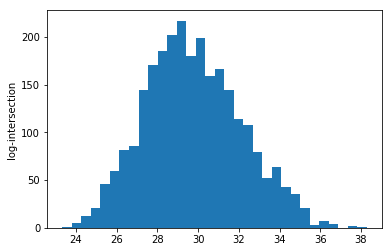

In [848]:
intersections = np.array(intersections)
intersections = np.array(sorted(intersections, key=lambda tup: tup[2], reverse=True))

log_intersections = np.log(1e-10 + intersections[:, 2])
print("log-intersections Mean", np.mean(log_intersections), "; log-intersections stddev", np.std(log_intersections))

# for i1, i2, card in intersections:
#     if abs(card) < 1e-2:
#         continue
#     print(hyp_wv.index2word[int(i1)], hyp_wv.index2word[int(i2)], round(card, 2))
    
# Plot intersections
plt.hist(log_intersections, bins="auto")
# plt.plot(range(len(intersections[:, 2])), log_intersections)
ax = plt.gca()
_ = ax.set_ylabel("log-intersection")

In [41]:
plot_ball_vectors(vectors=hyp_model.wv.vectors, x=top_and_bottom_levels_avg, model=hyp_model, word_dict=labeled_word_dict, ratio_words=1)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]  
[ (2,1) x4,y4 ]    [ (2,2) x5,y5 ]    [ (2,3) x6,y6 ]  
[ (3,1) x7,y7 ]    [ (3,2) x8,y8 ]    [ (3,3) x9,y9 ]  
[ (4,1) x10,y10 ]  [ (4,2) x11,y11 ]  [ (4,3) x12,y12 ]



In [42]:
plot_ball_vectors(recentered_vectors, top_levels_avg_norm, hyp_model, labeled_word_dict, ratio_words=1)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]  
[ (2,1) x4,y4 ]    [ (2,2) x5,y5 ]    [ (2,3) x6,y6 ]  
[ (3,1) x7,y7 ]    [ (3,2) x8,y8 ]    [ (3,3) x9,y9 ]  
[ (4,1) x10,y10 ]  [ (4,2) x11,y11 ]  [ (4,3) x12,y12 ]



In [43]:
rotated = rotate_mat(top_levels_avg_norm, top_levels_avg_norm.reshape(1, -1)).reshape(-1)
plot_ball_vectors(rotated_vectors, rotated, hyp_model, labeled_word_dict, ratio_words=1)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]  
[ (2,1) x4,y4 ]    [ (2,2) x5,y5 ]    [ (2,3) x6,y6 ]  
[ (3,1) x7,y7 ]    [ (3,2) x8,y8 ]    [ (3,3) x9,y9 ]  
[ (4,1) x10,y10 ]  [ (4,2) x11,y11 ]  [ (4,3) x12,y12 ]



In [ ]:
plot_ball_vectors(vectors=mix_poincare_moebius_mul_mat(hyp_model.wv.vectors, 3, 10), x=top_and_bottom_levels_avg, model=hyp_model, word_dict=labeled_word_dict, ratio_words=1)

## Gaussian std vs WordNet level

In [200]:
level2words = [[] for i in range(20)]
for ss in wn.all_synsets():
    word, pos, _ = ss.name().rsplit(".", 2)
    if pos != "n":
        continue
    level = ss.max_depth()
    level2words[level].append(word)
for level, word_list in enumerate(level2words):
    print(level, len(word_list), word_list[0])

0 1 entity
1 3 physical_entity
2 22 thing
3 223 whole
4 1541 congener
5 4573 organism
6 8174 benthos
7 14831 beachhead
8 13350 agon
9 13775 abort
10 10847 abdominoplasty
11 6590 realization
12 3706 male_orgasm
13 1967 double_fault
14 1144 spiccato
15 644 highland_fling
16 458 carp
17 223 domestic_carp
18 42 leather_carp
19 1 rock_hind


In [65]:
hyp_model_fn = os.path.join(ROOT, "models/glove/geometric_emb/glove_ep50_size100_lr0.05_vocab200000_mix-poincare_OPTmixradagrad_COOCCFUNClog_DISTFUNCdist-sq_NUMEMBS50_bias")
# hyp_model_fn = os.path.join(ROOT, "models/glove/geometric_emb/glove_ep50_size100_lr0.01_vocab200000_mix-poincare_OPTmixradagrad_COOCCFUNClog_DISTFUNCcosh-dist-sq_NUMEMBS50_bias")
hyp_model = Glove.load(hyp_model_fn)
hyp_wv = hyp_model.wv

In [71]:
gaussians = get_gaussians(hyp_model, unsupervised=True, scaling_factor=1.0, words_to_use=1000)

['the', 'of', 'and', 'in', 'to', 'a', 'is', 'was', 'for', 'as', 'on', 'that', 'with', 'by', 'it', 'he', 'at', 'from', 'his', 'an', 'this', 'be', 'are', 'i', 'not', 'which', 'or', 'has', 'were', 'but', 'have', 'also', 'one', 'first', 'had', 'their', 'they', 'who', 'new', 'its', 'after', 'been', 'her', 'there', 'other', 'all', 'she', 'when', 'two', 'would', 'more', 'can', 'into', 'time', 'some', 'only', 'about', 'article', 'you', 'no', 'during', 'if', 'may', 'most', 'up', 'school', 'out', 'then', 'such', 'used', 'many', 'him', 'where', 'over', 'will', 'than', 'years', 'so', 'these', 'between', 'being', 'made', 'world', 'city', 'them', 'later', 'while', 'well', 'known', 'people', 'part', 'state', 'united', 'university', 'national', 'both', 'before', 'through', 'however', 'under', 'any', 'use', 'three', 'born', 'since', 'states', 'year', 'became', 'like', 'war', 'work', 'american', 'name', 'second', 'now', 'until', 'south', 'because', 'including', 'film', 'same', 'do', 'team', 'just', 'sho

[1.         1.         1.         1.         0.99999994 1.
 1.         1.         1.         1.         1.         0.99999994
 0.99999994 1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99999994 1.
 0.99999994 1.         0.99999994 0.99999994 1.         0.99999994
 0.99999994 1.         1.         1.         1.         0.99999994
 0.99999994 1.         1.         1.         0.99999994 0.99999994
 1.         1.         1.         1.         1.         0.99999994
 1.         0.99999994]
HP shape (189533, 100)
Gaussians shape (189533, 50, 2)


[0.79116666, 0.63494176, 0.58055776, 0.52412695, 0.49393162, 0.48535082, 0.47932166, 0.48366198, 0.4776235, 0.46733332, 0.4658492, 0.4775132, 0.45402047, 0.4718997, 0.47551242, 0.44664225, 0.47667393, 0.44823182, 0.40152392]


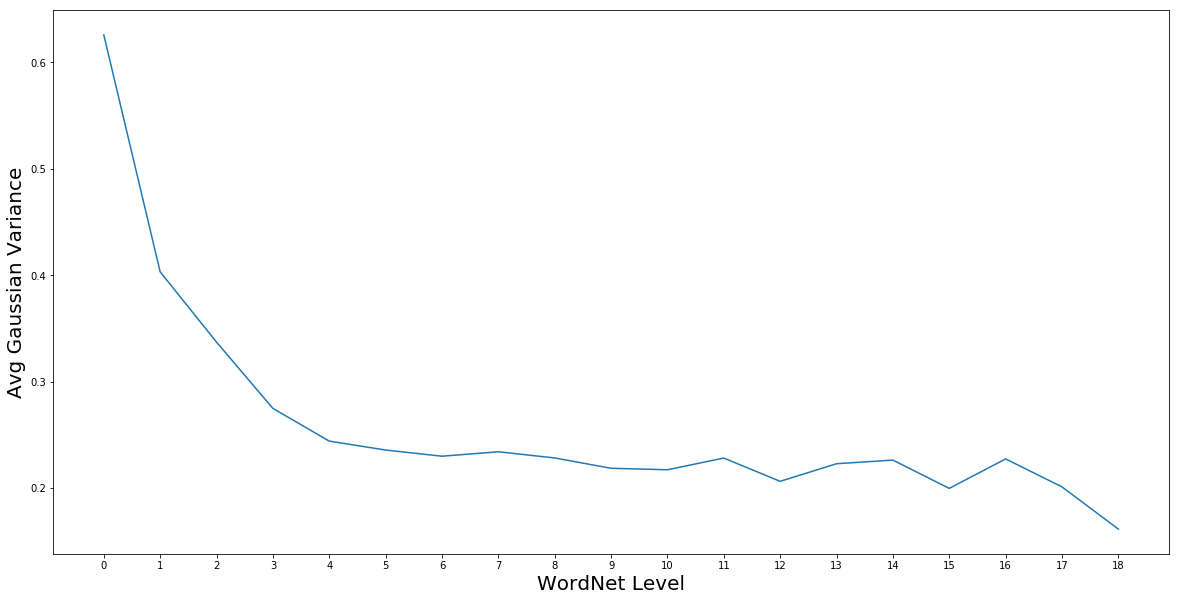

In [72]:
lvl_avg_std = []
lvl_std_std = []
for level, word_list in enumerate(level2words):
    word_idxs = np.array([hyp_wv.vocab[word].index for word in filter(lambda w: w in hyp_wv.vocab, word_list)])
    if word_idxs.size == 0:
        continue
    level_avg_std = np.mean(gaussians[word_idxs][:, 1])
    lvl_avg_std.append(level_avg_std)
    lvl_std_std.append(np.std(gaussians[word_idxs][:, 1]))
    
print(lvl_avg_std)
fig = plt.figure(figsize=(20,10))
plt.plot(range(len(lvl_avg_std)), np.array(lvl_avg_std)**2)
# plt.errorbar(range(len(lvl_avg_std)), lvl_avg_std, lvl_std_std, capsize=10, marker=".", markersize=14)
ax = plt.gca()
_ = ax.set_xticks(range(len(lvl_avg_std)))
_ = ax.set_xlabel("WordNet Level", fontsize=20)
_ = ax.set_ylabel("Avg Gaussian Variance", fontsize=20)

## Score depending on the sigma_factor

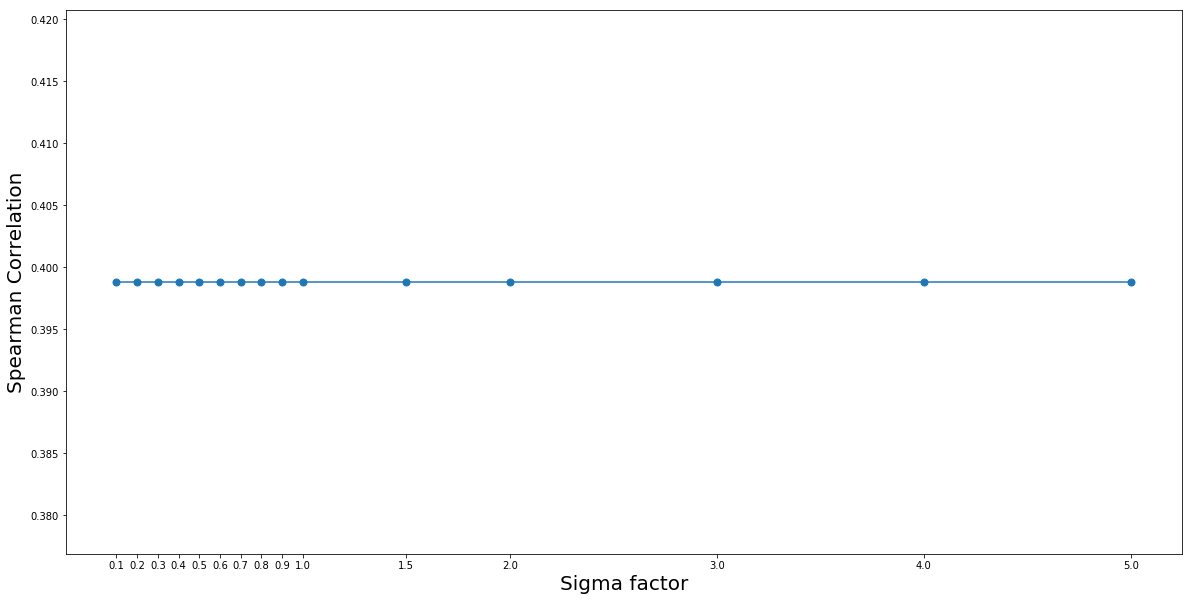

In [212]:
sigma_factors = np.concatenate((np.linspace(0.1, 1, 10), np.array([1.5, 2, 3, 4, 5])))
scores = []
for sigma_factor in sigma_factors:
    scores.append(get_hyperlex_score(sigma_factor=sigma_factor))
    
fig = plt.figure(figsize=(20,10))
plt.plot(sigma_factors, scores, marker=".", markersize=14)
ax = plt.gca()
_ = ax.set_xticks(sigma_factors)
_ = ax.set_xlabel("Sigma factor", fontsize=20)
_ = ax.set_ylabel("Spearman Correlation", fontsize=20)

## Nickel score depending on alpha on HyperLex

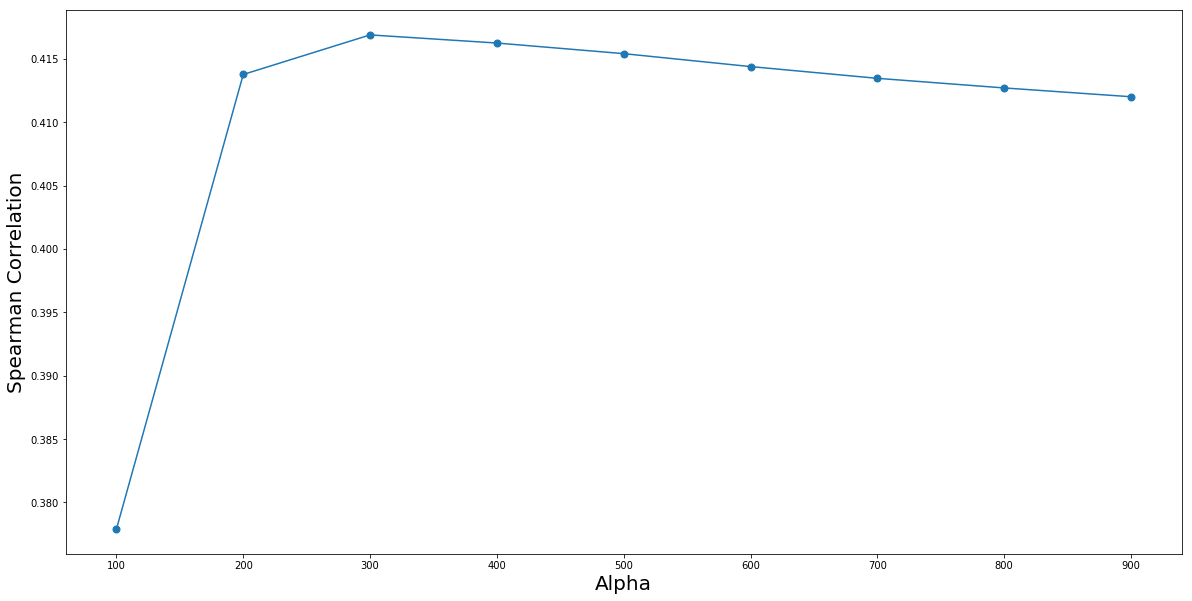

In [72]:
alphas = range(100, 1000, 100)
scores = []
for alpha in alphas:
    scores.append(get_hyperlex_score(alpha=alpha))
    
fig = plt.figure(figsize=(20,10))
plt.plot(alphas, scores, marker=".", markersize=14)
ax = plt.gca()
_ = ax.set_xticks(alphas)
_ = ax.set_xlabel("Alpha", fontsize=20)
_ = ax.set_ylabel("Spearman Correlation", fontsize=20)

## Check overlap between top5 + bottom5 levels of wordnet and hyperlex

In [891]:
wv = hyp_model.wv
wordnet_selected_words_file = os.path.join(ROOT, "msc_tifreaa/glove_code/data/wordnet_topmost_and_bottommost_words.txt")
top5_bottom5_wn_words = {}
with open(wordnet_selected_words_file, "r") as f:
    top5_bottom5_wn_words.update(dict([(word, wv.vocab[word].index) for word in filter(
        lambda w: w in wv.vocab and w not in hyperlex_vocab, f.readline().strip().split(" "))]))
#     f.readline()
    top5_bottom5_wn_words.update(dict([(word, wv.vocab[word].index) for word in filter(
        lambda w: w in wv.vocab and w not in hyperlex_vocab, f.readline().strip().split(" "))]))

print("Total words in top5 and bottom5 wordnet levels:", len(top5_bottom5_wn_words))
pair_overlap, word_overlap = 0, 0
for w1, w2, _, _, _ in hyperlex_data:
    pairs_are_overlapping = False
    if w1 in top5_bottom5_wn_words:
        pairs_are_overlapping = True
        word_overlap += 1
    if w2 in top5_bottom5_wn_words:
        word_overlap += 1
        pairs_are_overlapping = True
    if pairs_are_overlapping:
        pair_overlap += 1
print("HyperLex overlap:", pair_overlap, "out of", len(hyperlex_data),"pairs;", word_overlap, "out of", len(top5_bottom5_wn_words), "words")

pair_overlap, word_overlap = 0, 0
for w1, w2, _ in wbless_data:
    pairs_are_overlapping = False
    if w1 in top5_bottom5_wn_words:
        pairs_are_overlapping = True
        word_overlap += 1
    if w2 in top5_bottom5_wn_words:
        word_overlap += 1
        pairs_are_overlapping = True
    if pairs_are_overlapping:
        pair_overlap += 1
print("WBLESS overlap:", pair_overlap, "out of", len(wbless_data),"pairs;", word_overlap, "out of", len(top5_bottom5_wn_words), "words")

Total words in top5 and bottom5 wordnet levels: 1269
HyperLex overlap: 0 out of 2612 pairs; 0 out of 1269 words
WBLESS overlap: 238 out of 1668 pairs; 240 out of 1269 words


## WBLESS

In [13]:
gaussians = get_gaussians(hyp_model, scaling_factor=1.0)

wbless_file = os.path.join(ROOT, "data/BLESS_datasets/weeds_bless.json")
with open(wbless_file, "r") as f:
    wbless_data = json.load(f)

['entity', 'abstraction', 'thing', 'thing', 'attribute', 'freshener', 'horror', 'pacifier', 'stinker', 'otherworld', 'whole', 'cognition', 'motivation', 'phenomenon', 'curio', 'hoodoo', 'keepsake', 'stuff', 'subject', 'triviality', 'trait', 'thing', 'cheerfulness', 'ballast', 'ethos', 'eidos', 'inheritance', 'probability', 'depth', 'quantum', 'interval', 'contagion', 'indication', 'display', 'paring', 'arrangement', 'community', 'collection', 'edition', 'association', 'swarm', 'locus', 'subgroup', 'subset', 'sainthood', 'citizenry', 'population', 'multitude', 'diagonal', 'varna', 'series', 'commemorative', 'discard', 'finding', 'floater', 'growth', 'moon', 'neighbor', 'remains', 'reservoir', 'ribbon', 'sediment', 'shiner', 'vagabond', 'variable', 'web', 'nature', 'supernatural', 'theurgy', 'catalyst', 'operator', 'ownership', 'chelation', 'decrease', 'degeneration', 'development', 'encapsulation', 'execution', 'iteration', 'iteration', 'photography', 'processing', 'sensitization', 'sha

[0.99999994 0.99999994 1.         0.99999994 1.         0.99999994
 0.99999994 0.99999994 0.99999994 1.         1.         0.99999994
 1.         1.         1.         1.         1.         0.99999994
 0.99999994 1.0000001  1.         1.         0.99999994 1.
 0.99999994 1.         0.99999994 1.         1.         0.99999994
 0.99999994 1.         0.99999994 1.         1.         0.99999994
 0.99999994 1.         1.         0.99999994 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]
HP shape (189533, 100)
Gaussians shape (189533, 50, 2)


In [14]:
def wbless_get_is_a_score(w1_idx, w2_idx, gaussians, intersections=None, sigma_factor=1, **kwargs):
    v1, v2 = gaussians[w1_idx].reshape(-1, 2), gaussians[w2_idx].reshape(-1, 2)
    log_cardinal_v1 = v1.shape[0] * np.log(2 * sigma_factor) + np.log(v1[:, 1]).sum()
    log_cardinal_v2 = v2.shape[0] * np.log(2 * sigma_factor) + np.log(v2[:, 1]).sum()
    cos_sim = 0.0
    cardinal_intersection = 1.0
    for i in range(v1.shape[0]):
        m1, s1 = v1[i]
        m2, s2 = v2[i]
        s1 *= sigma_factor
        s2 *= sigma_factor
        a, b = m1 - s1, m1 + s1
        c, d = m2 - s2, m2 + s2
        if d > b:
            if c > a:
                cardinal_intersection = cardinal_intersection * max(0, b-c)
            else:
                cardinal_intersection = cardinal_intersection * (b-a)
        else:
            if c > a:
                cardinal_intersection = cardinal_intersection * (d-c)
            else:
                cardinal_intersection = cardinal_intersection * max(0, d-a)

        cos_sim += np.dot(m1, m2) / (np.linalg.norm(m1) + np.linalg.norm(m2) + 1e-10)

    if intersections != None:
        intersections.append((w1_idx, w2_idx, cardinal_intersection))
            
    cardinal_intersection = np.log(1e-10 + cardinal_intersection)
    return log_cardinal_v2-log_cardinal_v1
#     return 1 - log_cardinal_v1 / log_cardinal_v2 if cos_sim > 0.01 else 0.0

def wbless_eval(model, gaussians, sigma_factor=1.0, alpha=600):
    correct_count, total_count = 0.0, 0.0

    instances = []
    for w1, w2, label in wbless_data:
        if w1 not in model.wv.vocab or w2 not in model.wv.vocab:
            continue
        total_count += 1
        model_score = get_nickel_score(model.wv.vocab[w1].index, model.wv.vocab[w2].index, gaussians, 
                                            sigma_factor=sigma_factor, alpha=alpha)
        instances.append((w1, w2, label, model_score))
        
    threshold = np.mean(np.array([model_score for _, _, _, model_score in instances]))
    correct = list(filter(lambda instance: (instance[3] > threshold and instance[2] == 1) or (instance[3] <= threshold and instance[2] == 0), instances))
            
    print("Accuracy: {:.4f}, from a total of {}/{} pairs".format(
        float(len(correct)) / len(instances), len(instances), len(wbless_data)))
    return float(len(correct)) / len(instances)

_ = wbless_eval(hyp_model, gaussians, sigma_factor=1.0, alpha=600)

Accuracy: 0.7534, from a total of 1667/1668 pairs


## Nickel score depending on alpha on WBLESS

Accuracy: 0.7966, from a total of 1667/1668 pairs
Accuracy: 0.7966, from a total of 1667/1668 pairs
Accuracy: 0.7966, from a total of 1667/1668 pairs
Accuracy: 0.7966, from a total of 1667/1668 pairs
Accuracy: 0.7966, from a total of 1667/1668 pairs
Accuracy: 0.7966, from a total of 1667/1668 pairs
Accuracy: 0.7966, from a total of 1667/1668 pairs
Accuracy: 0.7966, from a total of 1667/1668 pairs
Accuracy: 0.7966, from a total of 1667/1668 pairs


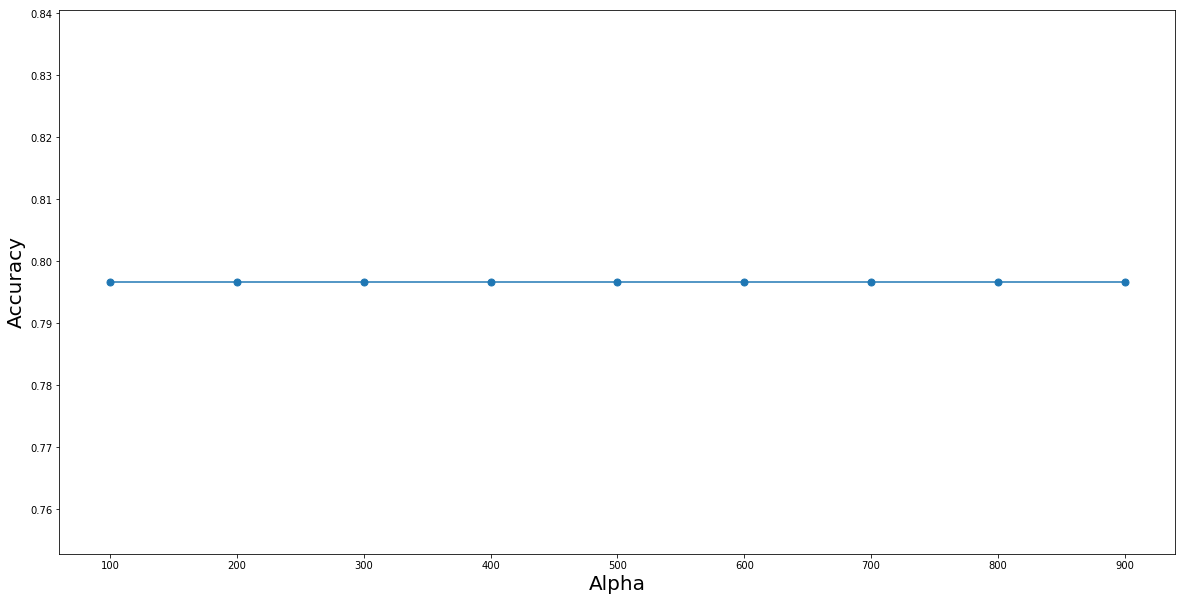

In [317]:
alphas = range(100, 1000, 100)
scores = []
for alpha in alphas:
    scores.append(wbless_eval(hyp_model, gaussians, alpha=alpha))
    
fig = plt.figure(figsize=(20,10))
plt.plot(alphas, scores, marker=".", markersize=14)
ax = plt.gca()
_ = ax.set_xticks(alphas)
_ = ax.set_xlabel("Alpha", fontsize=20)
_ = ax.set_ylabel("Accuracy", fontsize=20)

## HyperLex score vs number of words considered for determining the recentering/rotation

In [214]:
x = [10,20,30,40,50,75,100,200,300,400]
y = [0.26,0.37,0.36,0.38,0.37,0.39,0.40,0.40,0.42,0.41]
trace = go.Scatter(
    x = x,
    y = y,
    mode = 'lines+markers'
)
data = [trace]
gray = 'rgb(180, 180, 180)'
layout = dict(
    title = 'HyperLex score vs number of words considered for determining the recentering/rotation',
    xaxis = dict(title='# words', tickvals=[0, 10, 20] + list(range(50, 450, 50))),
    yaxis = dict(title='HyperLex Spearman correlation', tickvals=[0.26, 0.36, 0.42] + [0.1, 0.2, 0.3, 0.4], range=[0, 0.45]),
)
iplot(dict(data=data, layout=layout))

In [30]:
# Get vocabulary from WordNet + labels for each section
def read_word_dict():
    result_dict = dict([(str(level), word_list[:50] + word_list[50::10]) for level, word_list in enumerate(level2words)])
    return result_dict

def HSVToRGB(h, s, v):
    (r, g, b) = colorsys.hsv_to_rgb(h, s, v)
    return (int(255*r), int(255*g), int(255*b))

def get_colors(word_dict):
    labels = word_dict.keys()
    huePartition = 1.0 / (len(labels) + 1)
    return dict(zip(labels, [HSVToRGB(huePartition * value, 1.0, 1.0) for value in range(0, len(labels))]))

def plot_halfplane_wordnet_per_level(model, gaussians, word_dict, right_offset=None, left_offset=None, ratio_words=0.1, aggregate="w"):
    colors = get_colors(labeled_word_dict)

    wv = model.wv
    if aggregate == "w":
        vectors = model.wv.vectors    
    elif aggregate == "c":
        vectors = model.trainables.syn1neg   
    else:
        return None 
    
    embeddings = np.array([vectors[i] for i in range(len(wv.index2entity))])

    traces = []
    small_emb_size = int(model.vector_size / model.num_embs)
    rows = int(np.ceil(model.num_embs / PLOTS_PER_ROW))
    fig = tools.make_subplots(rows=rows, cols=PLOTS_PER_ROW)
    
    layout = {
        'width': PLOTS_PER_ROW * 300,
        'height': rows * 300
    }
    
    for level, words in word_dict.items():
        if int(level) in range(4, 16):
            continue
            
        idxs = [wv.vocab[w].index for w in filter(lambda w: w in wv.vocab, words)]
        idxs = idxs[:int(len(idxs) * ratio_words)]

        embs = gaussians[idxs, :]

        params = {}
        for i in range(model.num_embs):
            row = int(i / PLOTS_PER_ROW) + 1
            col = i % PLOTS_PER_ROW + 1

            trace = go.Scatter(
                x=embs[:, small_emb_size * i],
                y=embs[:, small_emb_size * i + 1],
                text=[wv.index2word[idx] for idx in idxs],
                textposition='top right',
                name=level,
                mode="markers",
                marker=dict(color="rgb"+str(colors[level])))
            fig.append_trace(trace, row, col)
            
#             if i == 0:
#                 layout["xaxis"] = {"range": (-1, 1)}
#                 layout["yaxis"] = {"range": (0, 3)}
#             else:
            layout["xaxis"+str(i+1)] = {"range": (-1, 1)}
            layout["yaxis"+str(i+1)] = {"range": (0, 3)}

    fig["layout"].update(layout)
    
    return iplot(fig)

labeled_word_dict = read_word_dict()
for lvl in labeled_word_dict:
    print(len(labeled_word_dict[lvl]))

1
3
22
68
200
503
863
1529
1380
1423
1130
704
416
242
160
110
91
68
42
1


## Points in the half-plane

In [44]:
halfplane = np.copy(gaussians)
halfplane[:, :, 0] *= np.sqrt(2)
plot_halfplane_wordnet_per_level(hyp_model, halfplane.reshape(-1, 20), labeled_word_dict, ratio_words=1,
                       left_offset=None, right_offset=None, aggregate="w")

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]  
[ (2,1) x4,y4 ]    [ (2,2) x5,y5 ]    [ (2,3) x6,y6 ]  
[ (3,1) x7,y7 ]    [ (3,2) x8,y8 ]    [ (3,3) x9,y9 ]  
[ (4,1) x10,y10 ]  [ (4,2) x11,y11 ]  [ (4,3) x12,y12 ]



## All isometries plot

In [128]:
# Get vocabulary from WordNet + labels for each section
def read_word_dict():
    result_dict = dict([(str(level), word_list[:50] + word_list[50::10]) for level, word_list in enumerate(level2words)])
    return result_dict

def HSVToRGB(h, s, v):
    (r, g, b) = colorsys.hsv_to_rgb(h, s, v)
    return (int(255*r), int(255*g), int(255*b))

def get_colors(word_dict):
    labels = word_dict.keys()
    huePartition = 1.0 / (len(labels) + 1)
    return dict(zip(labels, [HSVToRGB(huePartition * value, 1.0, 1.0) for value in range(0, len(labels))]))

def plot_ALL_wordnet_per_level(model, gaussians, space_ids, word_dict, ratio_words=0.1):
    global recentered_vectors, rotated_vectors
    colors = get_colors(labeled_word_dict)

    wv = model.wv

    ball_vectors = wv.vectors
    recentered_vectors = recentered_vectors
    rotated_vectors = rotated_vectors
    halfplane_vectors = np.copy(gaussians)
    halfplane_vectors[:, :, 0] *= np.sqrt(2)
    halfplane_vectors = halfplane_vectors.reshape(-1, 20)

    traces = []
    small_emb_size = int(model.vector_size / model.num_embs)
    rows = len(space_ids)
    fig = tools.make_subplots(rows=rows, cols=4)
    
    layout = {
        'width': 4 * 300,
        'height': len(space_ids) * 300
    }
    
    for level, words in word_dict.items():
        if int(level) in range(4, 16):
            continue
            
        idxs = [wv.vocab[w].index for w in filter(lambda w: w in wv.vocab, words)]
        idxs = idxs[:int(len(idxs) * ratio_words)]

        params = {}
        for i, space_id in enumerate(space_ids):
            # Plot initial ball.
            trace = go.Scatter(
                x=ball_vectors[idxs, small_emb_size * space_id],
                y=ball_vectors[idxs, small_emb_size * space_id + 1],
                text=[wv.index2word[idx] for idx in idxs],
                textposition='top right',
                showlegend=True if i == 0 else False,
                name=level,
                mode="markers",
                marker=dict(color="rgb"+str(colors[level])))
            fig.append_trace(trace, i+1, 1)
            
            # Plot ball after recentering.
            trace = go.Scatter(
                x=recentered_vectors[idxs, small_emb_size * space_id],
                y=recentered_vectors[idxs, small_emb_size * space_id + 1],
                text=[wv.index2word[idx] for idx in idxs],
                textposition='top right',
                showlegend=False,
                name=level,
                mode="markers",
                marker=dict(color="rgb"+str(colors[level])))
            fig.append_trace(trace, i+1, 2)
            
            # Plot ball after recentering and rotation.
            trace = go.Scatter(
                x=rotated_vectors[idxs, small_emb_size * space_id],
                y=rotated_vectors[idxs, small_emb_size * space_id + 1],
                text=[wv.index2word[idx] for idx in idxs],
                textposition='top right',
                showlegend=False,
                name=level,
                mode="markers",
                marker=dict(color="rgb"+str(colors[level])))
            fig.append_trace(trace, i+1, 3)
            
            # Plot halfplane.
            trace = go.Scatter(
                x=halfplane_vectors[idxs, small_emb_size * space_id],
                y=halfplane_vectors[idxs, small_emb_size * space_id + 1],
                text=[wv.index2word[idx] for idx in idxs],
                textposition='top right',
                showlegend=False,
                name=level,
                mode="markers",
                marker=dict(color="rgb"+str(colors[level])))
            fig.append_trace(trace, i+1, 4)
            layout["xaxis"+str(4*i+4)] = {"range": (-1, 1)}
            layout["yaxis"+str(4*i+4)] = {"range": (0, 3)}
            
    shapes = []
    for i, trace in enumerate(fig['data']):
        if (i+1) % 4 == 0:
            continue
        if i+1 > 4 * len(space_ids):
            break
        shapes.append(
            # unfilled circle
            {
                'type': 'circle',
                'xref': 'x'+str(i+1),
                'yref': 'y'+str(i+1),
                'x0': -1,
                'y0': -1,
                'x1': 1,
                'y1': 1,
                'line': {
                    'color': 'rgba(0, 0, 0, 1)',
                },
            }
        )

    layout['shapes'] = shapes

    fig["layout"].update(layout)
    
    return iplot(fig)

labeled_word_dict = read_word_dict()
for lvl in labeled_word_dict:
    print(len(labeled_word_dict[lvl]))

1
3
22
68
200
503
863
1529
1380
1423
1130
704
416
242
160
110
91
68
42
1


In [139]:
hyp_model_fn = os.path.join(ROOT, "models/glove/geometric_emb/glove_ep50_size20_lr0.05_vocab200000_mix-poincare_OPTmixradagrad_COOCCFUNClog_DISTFUNCdist-sq_NUMEMBS10_bias")
hyp_model = Glove.load(hyp_model_fn)
hyp_wv = hyp_model.wv

In [142]:
# Plot first 5 2D spaces.
plot_ALL_wordnet_per_level(hyp_model, gaussians, list(range(5)), labeled_word_dict, ratio_words=1)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]    [ (1,4) x4,y4 ]  
[ (2,1) x5,y5 ]    [ (2,2) x6,y6 ]    [ (2,3) x7,y7 ]    [ (2,4) x8,y8 ]  
[ (3,1) x9,y9 ]    [ (3,2) x10,y10 ]  [ (3,3) x11,y11 ]  [ (3,4) x12,y12 ]
[ (4,1) x13,y13 ]  [ (4,2) x14,y14 ]  [ (4,3) x15,y15 ]  [ (4,4) x16,y16 ]
[ (5,1) x17,y17 ]  [ (5,2) x18,y18 ]  [ (5,3) x19,y19 ]  [ (5,4) x20,y20 ]



In [143]:
# Plot last 5 2D spaces.
plot_ALL_wordnet_per_level(hyp_model, gaussians, list(range(5, 10)), labeled_word_dict, ratio_words=1)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]    [ (1,4) x4,y4 ]  
[ (2,1) x5,y5 ]    [ (2,2) x6,y6 ]    [ (2,3) x7,y7 ]    [ (2,4) x8,y8 ]  
[ (3,1) x9,y9 ]    [ (3,2) x10,y10 ]  [ (3,3) x11,y11 ]  [ (3,4) x12,y12 ]
[ (4,1) x13,y13 ]  [ (4,2) x14,y14 ]  [ (4,3) x15,y15 ]  [ (4,4) x16,y16 ]
[ (5,1) x17,y17 ]  [ (5,2) x18,y18 ]  [ (5,3) x19,y19 ]  [ (5,4) x20,y20 ]



## Cherry-picked hierarchies

In [174]:
hyp_model_fn = os.path.join(ROOT, "models/glove/geometric_emb/glove_ep50_size20_lr0.05_vocab200000_mix-poincare_OPTmixradagrad_COOCCFUNClog_DISTFUNCdist-sq_NUMEMBS10_bias")
hyp_model = Glove.load(hyp_model_fn)
hyp_wv = hyp_model.wv

In [175]:
gaussians = get_gaussians(hyp_model, scaling_factor=1.0, words_to_use=400)

['entity', 'abstraction', 'thing', 'thing', 'attribute', 'freshener', 'horror', 'pacifier', 'stinker', 'otherworld', 'whole', 'cognition', 'motivation', 'phenomenon', 'curio', 'hoodoo', 'keepsake', 'stuff', 'subject', 'triviality', 'trait', 'thing', 'cheerfulness', 'ballast', 'ethos', 'eidos', 'inheritance', 'probability', 'depth', 'quantum', 'interval', 'contagion', 'indication', 'display', 'paring', 'arrangement', 'community', 'collection', 'edition', 'association', 'swarm', 'locus', 'subgroup', 'subset', 'sainthood', 'citizenry', 'population', 'multitude', 'diagonal', 'varna', 'series', 'commemorative', 'discard', 'finding', 'floater', 'growth', 'moon', 'neighbor', 'remains', 'reservoir', 'ribbon', 'sediment', 'shiner', 'vagabond', 'variable', 'web', 'nature', 'supernatural', 'theurgy', 'catalyst', 'operator', 'ownership', 'chelation', 'decrease', 'degeneration', 'development', 'encapsulation', 'execution', 'iteration', 'iteration', 'photography', 'processing', 'sensitization', 'sha

[0.99999994 1.         1.         1.         1.         0.99999994
 1.         1.         1.         1.        ]
HP shape (189533, 20)
Gaussians shape (189533, 10, 2)


In [176]:
# Get vocabulary of the Google word analogy benchmark + labels for each section
def read_word_dict():
    result_dict = {
        "president": ["obama", "eisenhower", "roosevelt", "clinton", "jefferson", "kennedy", "lincoln", "nixon", "reagan"],
        "mathematics": ["geometry", "inequality", "arithmetic", "calculus", "algebra", "equation", "theorem"],
        "number": ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"],
        "chemistry": ["chemical", "oxygen", "carbon", "dioxide", "nitrogen", "chlorium", "zinc", "organic"],
        "sport": ["maradona", "ronaldo", "messi", "lochte", "phelps", "spitz", "comneci", "mayweather", "pacquiao"],
        "country": ["romania", "france", "germany", "england", "russia", "india", "china", "spain"],
    }
    return result_dict

def compute_poincare_aggregate(model):
    """
    Precompute the average between the target and the context vector, for Poincare embeddings.
    We take as average the mid point between w and c on the geodesic that connects the 2 points
    (see page 89 in Ungar book).
    """
    if model.poincare and getattr(model.wv, 'agg_vectors', None) is None:
        print("precomputing aggregated vectors w+c for Poincare embeddings")
        gamma_w_sq = 1 / (1 - np.sum(model.wv.vectors * model.wv.vectors, axis=1))
        gamma_c_sq = 1 / (1 - np.sum(model.trainables.syn1neg * model.trainables.syn1neg, axis=1))
        denominator = gamma_w_sq + gamma_c_sq - 1
        agg = (model.wv.vectors * (gamma_w_sq / denominator)[:, None] +
               model.trainables.syn1neg * (gamma_c_sq / denominator)[:, None])

        return model.wv.moebius_mul_mat(agg, 0.5)

def HSVToRGB(h, s, v):
    (r, g, b) = colorsys.hsv_to_rgb(h, s, v)
    return (int(255*r), int(255*g), int(255*b))

def get_colors(word_dict):
    labels = word_dict.keys()
    huePartition = 1.0 / (len(labels) + 1)
    return dict(zip(labels, [HSVToRGB(huePartition * value, 1.0, 1.0) for value in range(0, len(labels))]))

def plot_wordnet_embeddings(model, gaussians, word_dict, left_offset=None, right_offset=None, ratio_words=1, aggregate="w"):
    colors = get_colors(labeled_word_dict)
    if aggregate == "w+c":
        vectors = compute_poincare_aggregate(model)
    elif aggregate == "w":
        vectors = model.wv.vectors    
    elif aggregate == "c":
        vectors = model.trainables.syn1neg   
    else:
        return None   
    wv = model.wv
    
    embeddings = gaussians.reshape(-1, 20)  # np.array([vectors[i] for i in range(len(wv.index2entity))])
    traces = []
    
    
    rows = int(np.ceil(model.num_embs / PLOTS_PER_ROW))
    fig = tools.make_subplots(rows=rows, cols=PLOTS_PER_ROW)
    for label, words in word_dict.items():
        idxs = [wv.vocab[w].index for w in filter(lambda w: w in wv.vocab, words+[label])]
        idxs = idxs[:int(len(idxs) * ratio_words)]
        
        label_idx = wv.vocab[label].index
        
        embs = embeddings[idxs, :]

        small_emb_size = int(model.vector_size / model.num_embs)
        for i in range(model.num_embs):
            row = int(i / PLOTS_PER_ROW) + 1
            col = i % PLOTS_PER_ROW + 1
            trace = go.Scatter(
                x=embs[:, small_emb_size * i],
                y=embs[:, small_emb_size * i + 1],
                text=[wv.index2word[idx] for idx in idxs],
                textposition='top right',
                name=label,
                mode="markers+text",
                marker=dict(color="rgb"+str(colors[label])))
            fig.append_trace(trace, row, col)
            
    layout = {
        'width': PLOTS_PER_ROW * 300,
        'height': rows * 300
    }
    
    for i, trace in enumerate(fig['data']):
#         if i > 0: 
#             trace['showlegend'] = False
        layout['xaxis'+str(i+1)] = {
                'range': [-1, 1],
            }
        layout['yaxis'+str(i+1)] = {
                'range': [0, 3],
            }
        
    fig["layout"].update(layout)
    
    return iplot(fig)

labeled_word_dict = read_word_dict()
len(labeled_word_dict)

6

In [226]:
# Get vocabulary of the Google word analogy benchmark + labels for each section
def read_word_dict():
    result_dict = {
        "president": (0, 1, 0, -20, ["obama", "clinton", "trump", "eisenhower"]),
        "number": (2, 2, 0, -20, ["one", "two", "three", "four", "five", "six", "seven", "eight"]),
        "chemistry": (4, 3, 0, -20, ["oxygen", "carbon", "dioxide", "nitrogen", "chlorium", "organic"]),
        "sport": (6, 4, 0, -20, ["maradona", "messi", "lochte", "phelps", "pacquiao"]),
    }
    return result_dict

def compute_poincare_aggregate(model):
    """
    Precompute the average between the target and the context vector, for Poincare embeddings.
    We take as average the mid point between w and c on the geodesic that connects the 2 points
    (see page 89 in Ungar book).
    """
    if model.poincare and getattr(model.wv, 'agg_vectors', None) is None:
        print("precomputing aggregated vectors w+c for Poincare embeddings")
        gamma_w_sq = 1 / (1 - np.sum(model.wv.vectors * model.wv.vectors, axis=1))
        gamma_c_sq = 1 / (1 - np.sum(model.trainables.syn1neg * model.trainables.syn1neg, axis=1))
        denominator = gamma_w_sq + gamma_c_sq - 1
        agg = (model.wv.vectors * (gamma_w_sq / denominator)[:, None] +
               model.trainables.syn1neg * (gamma_c_sq / denominator)[:, None])

        return model.wv.moebius_mul_mat(agg, 0.5)

def HSVToRGB(h, s, v):
    (r, g, b) = colorsys.hsv_to_rgb(h, s, v)
    return (int(255*r), int(255*g), int(255*b))

def get_colors(word_dict):
    labels = word_dict.keys()
    huePartition = 1.0 / (len(labels) + 1)
    return dict(zip(labels, [HSVToRGB(huePartition * value, 1.0, 1.0) for value in range(0, len(labels))]))

def plot_wordnet_embeddings(model, gaussians, word_dict, left_offset=None, right_offset=None, ratio_words=1, aggregate="w"):
    colors = get_colors(labeled_word_dict)
    if aggregate == "w+c":
        vectors = compute_poincare_aggregate(model)
    elif aggregate == "w":
        vectors = model.wv.vectors    
    elif aggregate == "c":
        vectors = model.trainables.syn1neg   
    else:
        return None   
    wv = model.wv

    embeddings = gaussians.reshape(-1, 20)  # np.array([vectors[i] for i in range(len(wv.index2entity))])
    traces = []

    fig = tools.make_subplots(rows=1, cols=4)
    annotations = []
    for label, values in word_dict.items():
        dim, col, ax, ay, words = values
        idxs = [wv.vocab[w].index for w in filter(lambda w: w in wv.vocab, words+[label])]
        idxs = idxs[:int(len(idxs) * ratio_words)]
        print(label, col, dim)
        label_idx = wv.vocab[label].index
        
        embs = embeddings[idxs, :]
        small_emb_size = int(model.vector_size / model.num_embs)
        
        trace = go.Scatter(
            x=embs[:, small_emb_size * dim],
            y=embs[:, small_emb_size * dim + 1],
            text=[wv.index2word[idx] for idx in idxs],
            textposition='top right',
            name=label,
            mode="markers+text",
            marker=dict(color="rgb"+str(colors[label])))
        fig.append_trace(trace, 1, col)

    layout = {
        'width': 4 * 300,
        'height': 1 * 300
    }

    layout["annotations"] = annotations

    for i, trace in enumerate(fig['data']):
#         if i > 0: 
#             trace['showlegend'] = False
        layout['xaxis'+str(i+1)] = {
                'range': [-1, 1],
            }
        layout['yaxis'+str(i+1)] = {
                'range': [0, 3],
            }
        
    fig["layout"].update(layout)
    
    return iplot(fig)

labeled_word_dict = read_word_dict()
len(labeled_word_dict)

4

In [252]:
plot_wordnet_embeddings(hyp_model, gaussians, labeled_word_dict, ratio_words=1)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]  [ (1,4) x4,y4 ]

president 1 0
number 2 2
chemistry 3 4
sport 4 6


## Hypernyms of cherrypicked words

In [5]:
hyp_model_fn = os.path.join(ROOT, "models/glove/geometric_emb/glove_ep50_size100_lr0.05_vocab200000_mix-poincare_OPTmixradagrad_COOCCFUNClog_DISTFUNCdist-sq_NUMEMBS50_bias")
hyp_model = Glove.load(hyp_model_fn)
hyp_wv = hyp_model.wv

In [8]:
gaussians = get_gaussians(hyp_model, scaling_factor=1.0, words_to_use=400)

400 words from the TOP-most levels were selected
400 words from the BOTTOM-most levels were selected
[1.         0.99999994 1.         1.         1.         1.
 1.         1.         1.         1.         0.99999994 1.
 1.         1.         1.         1.         0.99999994 0.99999994
 0.99999994 1.         1.         1.         1.         0.99999994
 1.         1.         1.         1.         1.         1.
 0.99999994 1.         1.0000001  1.         1.         1.
 0.99999994 1.         1.         1.         1.         1.
 1.         0.99999994 1.         0.99999994 0.99999994 1.
 1.         1.        ]
HP shape (189533, 100)
Gaussians shape (189533, 50, 2)


In [25]:
def get_knn(query, curr_wv, k=10, restrict_vocab=200000):
    index = curr_wv.vocab[query].index
    limited = curr_wv.vectors[:restrict_vocab]
    dists = curr_wv.distances(curr_wv.vectors[index], limited)[0]
    knn_indexes = gensim.matutils.argsort(dists, topn=k)
    return list(zip([curr_wv.index2word[idx] for idx in knn_indexes], 
                    np.around(dists[knn_indexes], decimals=3), 
                    [norm(hyp_wv.vectors[idx]) for idx in knn_indexes]))

words = ['']
# for word in words:
word = 'music'
neighbors = [neigh for neigh, dist, w_norm in get_knn(word, k=100, curr_wv=hyp_model.wv)]
# print(neighbors)
scores = [get_is_a_score(hyp_model.wv.vocab[word].index, hyp_model.wv.vocab[w2].index, gaussians, 
                        sigma_factor=1.0, alpha=None) for w2 in neighbors]
print(word)
print([word for word, _ in sorted(zip(neighbors, scores), key=lambda x: -x[1])])
print("=====================================")

music
['work', 'performance', 'writing', 'music', 'literature', 'musical', 'composition', 'creative', 'works', 'media', 'well', 'contemporary', 'art', 'classical', 'songs', 'addition', 'electronic', 'video', 'shows', 'sound', 'poetry', 'play', 'recording', 'drama', 'collaboration', 'album', 'genre', 'sounds', 'compilation', 'lyrics', 'performances', 'videos', 'pop', 'feature', 'albums', 'compositions', 'arts', 'scene', 'theme', 'song', 'studio', 'performing', 'country', 'comedy', 'live', 'instrumental', 'vocal', 'concerts', 'dance', 'repertoire', 'voice', 'popular', 'concert', 'radio', 'cinema', 'folk', 'melody', 'inspired', 'band', 'rock', 'label', 'orchestral', 'artists', 'classic', 'soundtrack', 'indie', 'featured', 'recordings', 'bands', 'singing', 'hip-hop', 'tune', 'performed', 'ensemble', 'composers', 'artist', 'notably', 'piano', 'musicians', 'performers', 'solo', 'hop', 'recorded', 'guitar', 'duo', 'rap', 'composer', 'performer', 'acclaimed', 'jazz', 'featuring', 'classics', '